In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
airport_traffic_file_path = '/content/drive/My Drive/Flight Data/Airport_Traffic.csv'
city_mappings_file_path = '/content/drive/My Drive/Flight Data/city-mappings.csv'

In [ ]:
import pandas as pd

In [ ]:
# Load the Excel file
airport_traffic_df = pd.read_csv(airport_traffic_file_path, low_memory=False)

object_columns = airport_traffic_df.select_dtypes(include=['object']).columns
airport_traffic_df[object_columns] = airport_traffic_df[object_columns].astype('string')

# Load the CSV file
city_mappings_df = pd.read_csv(city_mappings_file_path)

In [ ]:
merged_df = airport_traffic_df.merge(city_mappings_df, left_on='APT_ICAO', right_on='four_digit')
merged_df = merged_df.drop(columns=['APT_NAME', 'STATE_NAME', 'index', 'three-digit code', 'four_digit'])
object_columns = ['APT_ICAO', 'Airport Name', 'City', 'Country']
for col in object_columns:
    merged_df[col] = merged_df[col].astype('string')

merged_df.head()

,APT_ICAO,FLT_DEP_1,FLT_ARR_1,Airport Name,City,Country,l1,l2
0,EBAW,4,3,Antwerp International Airport (Deurne),Antwerp,Belgium,51.1894,4.46028
1,EBAW,9,11,Antwerp International Airport (Deurne),Antwerp,Belgium,51.1894,4.46028
2,EBAW,10,17,Antwerp International Airport (Deurne),Antwerp,Belgium,51.1894,4.46028
3,EBAW,18,17,Antwerp International Airport (Deurne),Antwerp,Belgium,51.1894,4.46028
4,EBAW,12,13,Antwerp International Airport (Deurne),Antwerp,Belgium,51.1894,4.46028


In [ ]:
# Grouping by 'APT_ICAO' and summing 'FLT_DEP_1' and 'FLT_ARR_1', while keeping other details
grouped_df = merged_df.groupby('APT_ICAO').agg({
    'FLT_DEP_1': 'sum',
    'FLT_ARR_1': 'sum',
    'Airport Name': 'first',  # Keeping the first occurrence of non-numeric details
    'City': 'first',
    'Country': 'first',
    'l1': 'first',
    'l2': 'first'
}).reset_index()

In [ ]:
grouped_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323 entries, 0 to 322
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   APT_ICAO      323 non-null    string 
 1   FLT_DEP_1     323 non-null    int64  
 2   FLT_ARR_1     323 non-null    int64  
 3   Airport Name  323 non-null    string 
 4   City          323 non-null    string 
 5   Country       323 non-null    string 
 6   l1            323 non-null    float64
 7   l2            323 non-null    float64
dtypes: float64(2), int64(2), string(4)
memory usage: 20.3 KB


In [ ]:
grouped_df

,APT_ICAO,FLT_DEP_1,FLT_ARR_1,Airport Name,City,Country,l1,l2
0,EBAW,51934,52021,Antwerp International Airport (Deurne),Antwerp,Belgium,51.189400,4.460280
1,EBBR,731570,731660,Brussels Airport,Brussels,Belgium,50.901402,4.484440
2,EBCI,190198,189889,Brussels South Charleroi Airport,Charleroi,Belgium,50.459202,4.453820
3,EBLG,136631,136667,Liège Airport,Liege,Belgium,50.637402,5.443220
4,EBOS,27011,27261,Ostend-Bruges International Airport,Ostend,Belgium,51.198898,2.862220
...,...,...,...,...,...,...,...,...
318,LYPG,46262,46267,Podgorica Airport,Podgorica,Montenegro,42.359402,19.251900
319,LZIB,72415,72666,M. R. Štefánik Airport,Bratislava,Slovakia,48.170200,17.212700
320,UDYZ,95992,95816,Zvartnots International Airport,Yerevan,Armenia,40.147301,44.395901
321,UGTB,111278,111283,Tbilisi International Airport,Tbilisi,Georgia,41.669201,44.954700


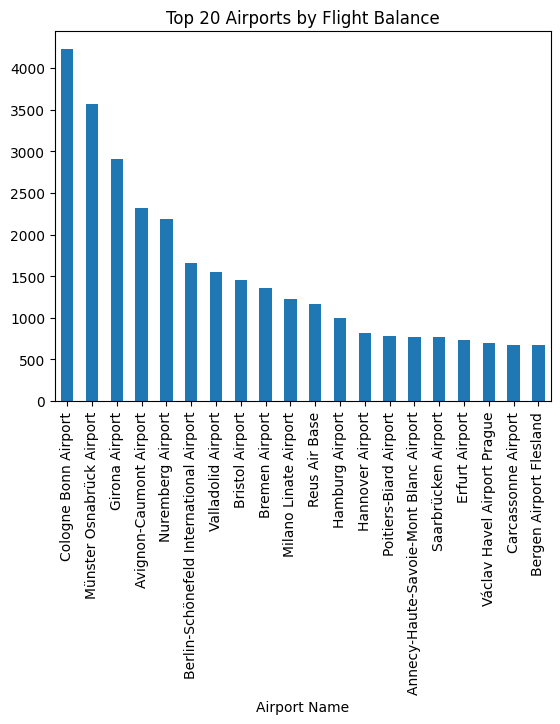

In [ ]:
top_n = 20  # You can adjust N based on your preference
top_airports_by_balance = grouped_df.nlargest(top_n, 'Flight Balance')
top_airports_by_balance.set_index('Airport Name')['Flight Balance'].plot(kind='bar', title=f'Top {top_n} Airports by Flight Balance')
plt.show()

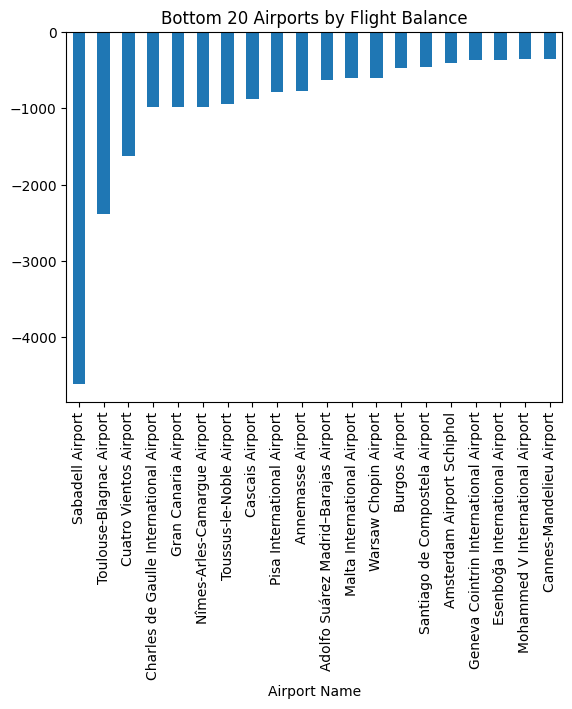

In [ ]:
bottom_n = 20  # You can adjust N based on your preference
bottom_airports_by_balance = grouped_df.nsmallest(bottom_n, 'Flight Balance')
bottom_airports_by_balance.set_index('Airport Name')['Flight Balance'].plot(kind='bar', title=f'Bottom {bottom_n} Airports by Flight Balance')
plt.show()

In [ ]:
correlation = grouped_df['FLT_DEP_1'].corr(grouped_df['FLT_ARR_1'])
print(f"Correlation between departures and arrivals: {correlation}")

Correlation between departures and arrivals: 0.9999977519517593


In [ ]:
import folium
from folium.plugins import HeatMap

In [ ]:
# Initialize a map centered on Europe for departures
map_departures = folium.Map(location=[54.5260, 15.2551], zoom_start=4)

# Loop through the dataframe to add departure markers
for index, row in grouped_df.iterrows():
    # Scale the departures for marker size
    marker_size_dep = row['FLT_DEP_1'] / 100000  # Example scaling

    # Add marker for departures to the map
    folium.CircleMarker(
        location=[row['l1'], row['l2']],
        radius=marker_size_dep,
        tooltip=f"{row['Airport Name']} - Departures: {row['FLT_DEP_1']}",
        color='blue',
        fill=True,
        fill_color='blue'
    ).add_to(map_departures)

# Save the departures map to an HTML file
map_departures

In [ ]:
# Initialize a map centered on Europe for arrivals
map_arrivals = folium.Map(location=[54.5260, 15.2551], zoom_start=4)

# Loop through the dataframe to add arrival markers
for index, row in grouped_df.iterrows():
    # Scale the arrivals for marker size
    marker_size_arr = row['FLT_ARR_1'] / 100000  # Example scaling

    # Add marker for arrivals to the map
    folium.CircleMarker(
        location=[row['l1'], row['l2']],
        radius=marker_size_arr,
        tooltip=f"{row['Airport Name']} - Arrivals: {row['FLT_ARR_1']}",
        color='green',
        fill=True,
        fill_color='green'
    ).add_to(map_arrivals)

# Save the arrivals map to an HTML file
map_arrivals

In [ ]:
import folium
from folium import FeatureGroup, LayerControl
from folium.plugins import HeatMap

# Assuming 'grouped_df' is your dataframe with the airport data

# Initialize a map centered on Europe
map = folium.Map(location=[54.5260, 15.2551], zoom_start=4)

# Create heatmaps for departures and arrivals
heat_departures = [[row['l1'], row['l2'], row['FLT_DEP_1']] for index, row in grouped_df.iterrows()]
heat_arrivals = [[row['l1'], row['l2'], row['FLT_ARR_1']] for index, row in grouped_df.iterrows()]

# Create feature groups for departures and arrivals
fg_departures = FeatureGroup(name='Departures Heatmap')
fg_arrivals = FeatureGroup(name='Arrivals Heatmap')

# Add heatmaps to the feature groups
HeatMap(heat_departures).add_to(fg_departures)
HeatMap(heat_arrivals).add_to(fg_arrivals)

# Add feature groups to the map
fg_departures.add_to(map)
fg_arrivals.add_to(map)

# Add layer control to the map
LayerControl().add_to(map)

# Save or display the map
map  # Uncomment to display in a Jupyter notebook